In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os 
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from models.simple_NAT import VaeTransformer, vae_loss

In [2]:
df = pd.read_csv('../smiles_selfies_full.csv')
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
MAKS = "<MASK>"
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [MAKS, PAD, SOS, EOS] + vocab
vocab_size = len(vocab)

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def full_molecule_tokens_to_ids(tokens, tok2id):
    return np.array([2] + [tok2id[t] for t in tokens] + [3])

df['token_ids'] = df['tokens'].apply(lambda toks: full_molecule_tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.ones((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Data shapes: Train {train_data.shape}, Val {val_data.shape}, Test {test_data.shape}")

Data shapes: Train (635522, 77), Val (79440, 77), Test (79441, 77)


In [3]:
device = 'cuda'
training_dict = torch.load("trained_models/NAT_128.pt", map_location=device)
vocab_size = training_dict["vocab_size"]
hidden_size = 128
latent_size = 128
attention_heads = 8
# latent_size = training_dict['latent_size']
# hidden_size = training_dict['hidden_size']
# embed_size = training_dict['embed_size']
# print(f"hidden_size={hidden_size}, embed_size={embed_size}, latent_size={latent_size}")

In [4]:
model = VaeTransformer(vocab_size, hidden_size, latent_size, max_len=max_len, attn_heads=attention_heads).to(device)
model.load_state_dict(training_dict['model_state_dict'])

<All keys matched successfully>

### Accuracies

In [5]:
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

In [6]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

x = val_data[0:1]
print(x.shape)
x = torch.tensor(x, device=device)
logits, mu, logvar = model(x)
print(logits.shape)
tokens = torch.argmax(logits, dim=-1)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 77)
torch.Size([1, 77, 111])
['<SOS>', '[C]', '[C]', '[C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[Ring1]', '[#Branch1]', '[=C]', '[Ring1]', '[O]', '[C]', '[=N]', '[N]', '[Ring2]', '[Ring1]', '[Ring2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '[C]', '[C]', '[C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[Ring1]', '[#Branch1]', '[=C]', '[Ring1]', '[O]', '[C]', 

In [9]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

def get_accuracy_samples(model, loader, pad_id=0, num_samples=5):
    model.eval()    
    for _ in range(num_samples):
        i = np.random.randint(0, len(data))
        x = data[i]
        x = x[np.newaxis, :]
        x_t = torch.tensor(x, device='cuda')
        logits, mu, logvar = model(x)
        x_rec = torch.argmax(logits, dim=-1)
        acc, pad = 0, 0
        j = 0
        x = x.squeeze(0)
        x_rec = x_rec.squeeze(0)
        while x[j] != pad_id:
            pad += 1
            if x[j] == x_rec[j]:
                acc += 1
            j+=1
        acc = acc / pad
        print(f"real: {tokens_to_selfie(x)}")
        print(f"rec: {tokens_to_selfie(x_rec)}")
        print(f"accuracy: {acc}")
        print('------------------------------')

In [10]:
get_accuracy_samples(model, val_data, pad_id=1, num_samples=5)

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not numpy.ndarray

In [11]:
def accuracy(model, loader, pad_id=1, device='cuda'):
    model.eval()
    for x in loader:
        x = x.to(device)
        logits, mu, logvar = model(x)
        preds = torch.argmax(logits, dim=-1)
        mask = (x != pad_id)
        correct_tokens = (preds == x) & mask
        token_acc = correct_tokens.sum().float() / (mask.sum().float() + 1e-8)
        seq_correct = ((preds == x) | ~mask).all(dim=1)
        seq_acc = seq_correct.float().mean()
    return token_acc, seq_acc

In [12]:
token_acc, seq_acc = accuracy(model, val_loader)
print(f'token_acc={token_acc}')
print(f'seq_acc={seq_acc}')

token_acc=0.9897072911262512
seq_acc=0.762499988079071


### Visualisations

In [24]:
n_samples = 100000
vis_data = data[:n_samples]
vis_loader = DataLoader(vis_data, shuffle=False)
zs = []
with torch.no_grad():
    for x in tqdm(vis_loader):
        x = x.to(device)
        logits, mu, logvar = model(x)
        zs.append(mu.cpu().numpy())

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:03<00:00, 1563.27it/s]


TypeError: concatenate() got an unexpected keyword argument 'dim'

In [25]:
z = np.concatenate(zs, axis=0)
z.shape

(100000, 128)

In [26]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

(5000, 128)

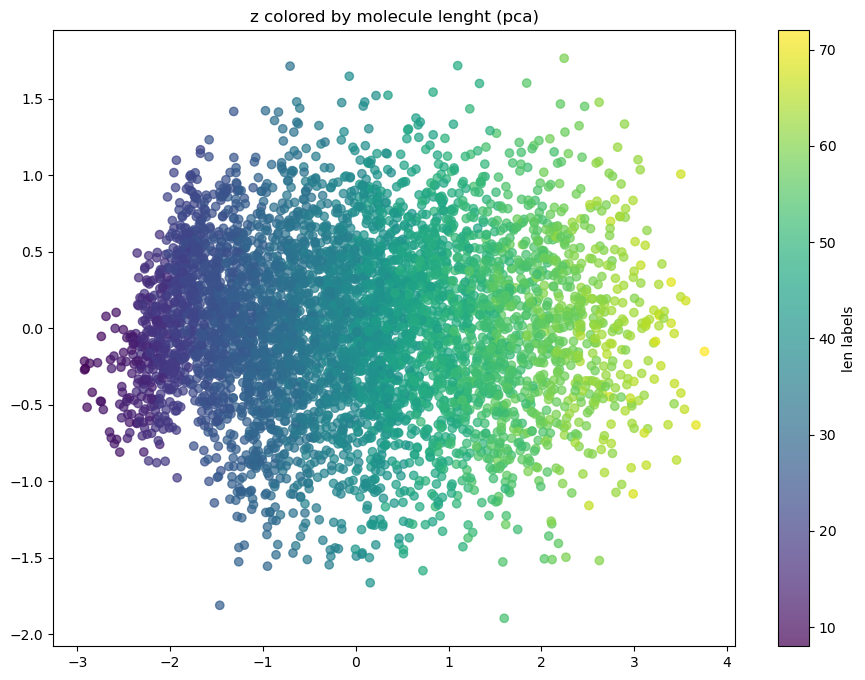

In [27]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

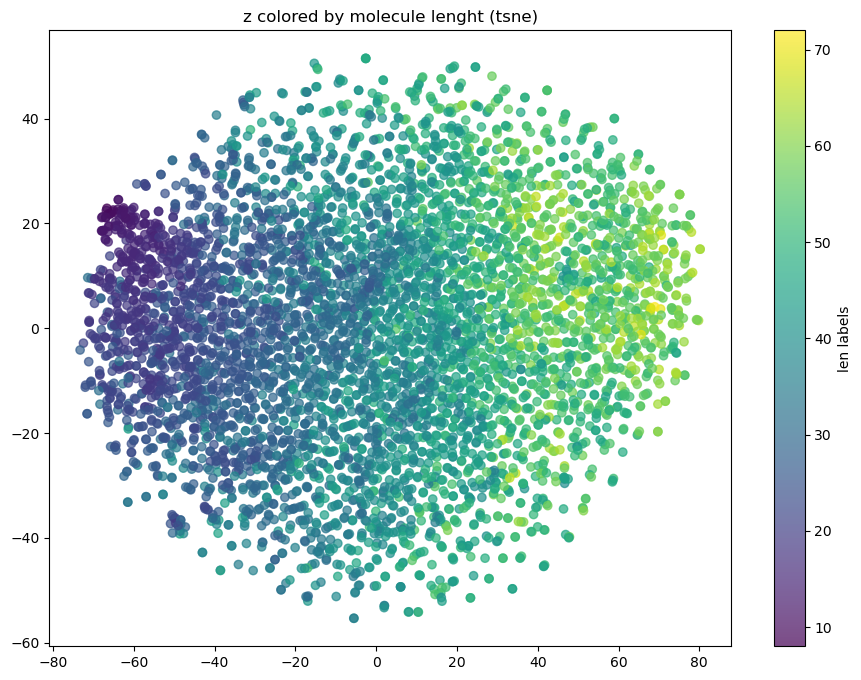

In [28]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (tsne)')
plt.colorbar(label='len labels')
plt.show()

In [29]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

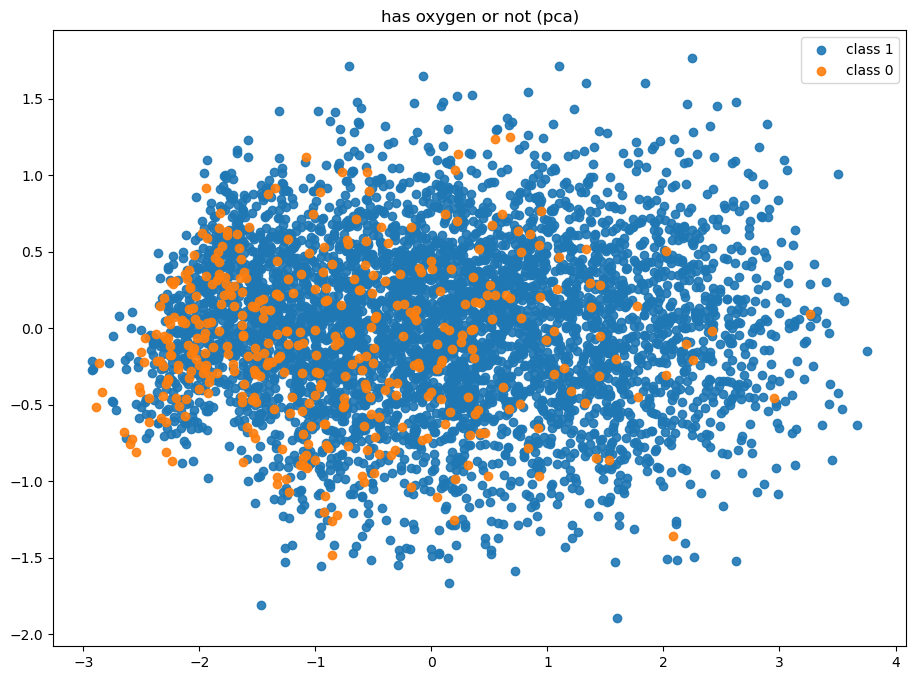

In [30]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

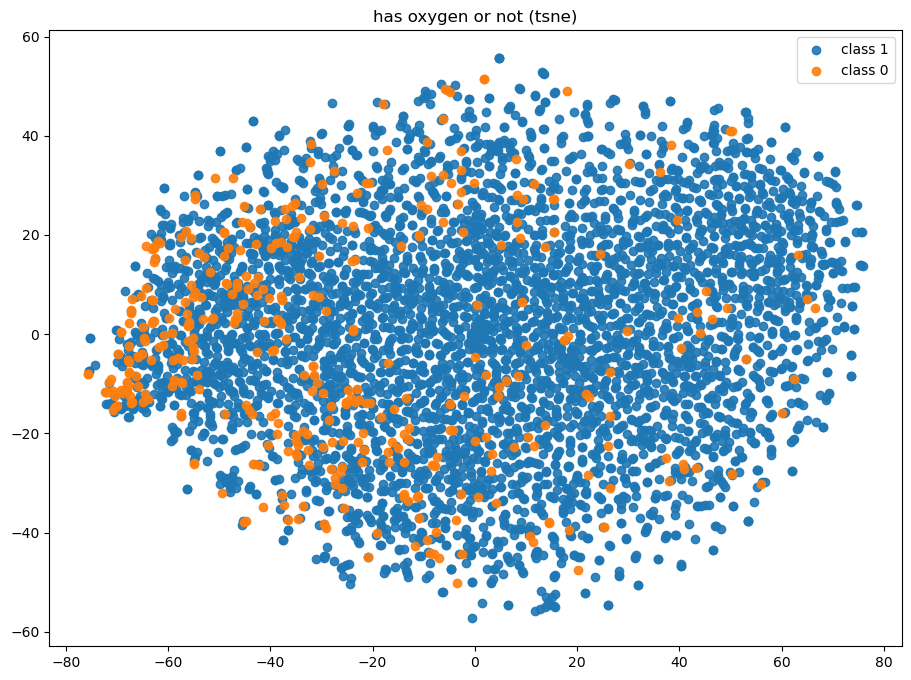

In [31]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (tsne)')
plt.legend()
plt.show()

In [32]:
carbon_label =  df['selfies'].apply(lambda x: x.count('C'))[idxs]

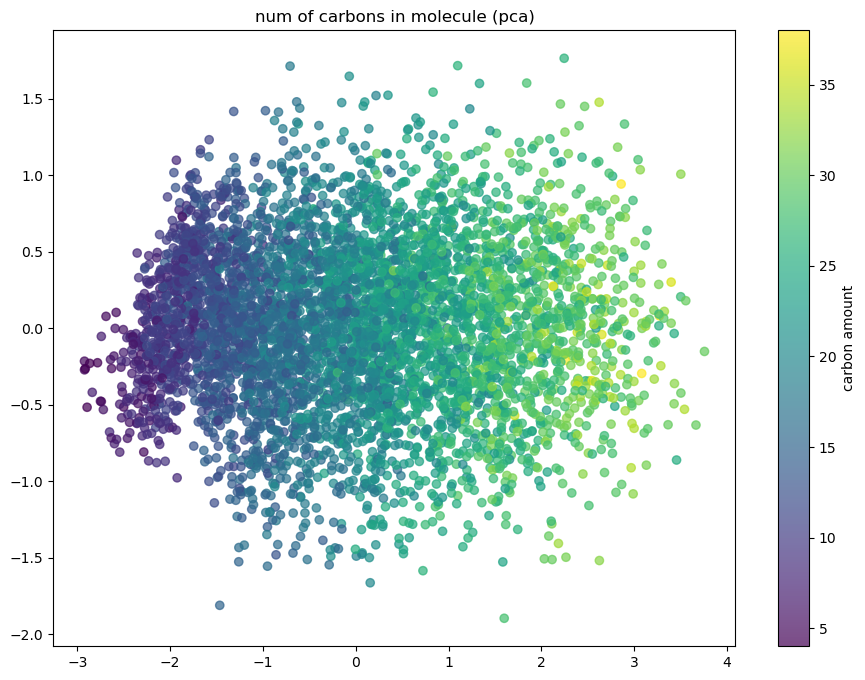

In [33]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (pca)')
plt.colorbar(label='carbon amount')
plt.show()

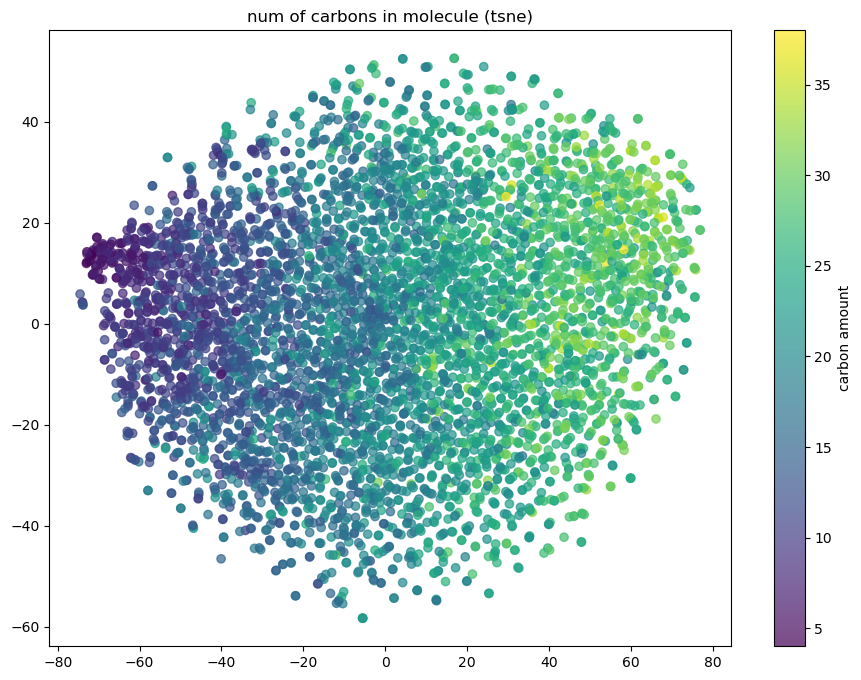

In [34]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (tsne)')
plt.colorbar(label='carbon amount')
plt.show()

### Validity of Latent Space

In [35]:
def cleaned_selfie(tokens):
    cleaned = []
    for tok in tokens:
        if tok == "<SOS>" or tok == "PAD":
            pass
        if tok == "<EOS>":
            break
        else:
            cleaned.append(tok)
    return cleaned

def sample_and_check(model, latent_size=128, n=1000):
    z = torch.randn((n, latent_size), device='cuda')
    with torch.no_grad():
        model.eval()
        logits = model.decode(z)
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    valid_pct = 0
    for ids in preds:
        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfie = "".join(toks).replace("<PAD>", "")
        try:
            smiles = sf.decoder(selfie)
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_pct += 1
        except:
            pass
    return z, valid_pct / n

In [37]:
z, valid_pct = sample_and_check(model, latent_size=latent_size)
z = z.cpu().numpy()
print(f'validality % of latent space: {valid_pct*100}%')

validality % of latent space: 99.2%


In [64]:
def count_duplicates(lst):
    if not lst:
        return [], []
    unique = [lst[0]]
    counts = [1]
    for x in lst[1:]:
        if x == unique[-1]:
            counts[-1] += 1
        else:
            unique.append(x)
            counts.append(1)
    return unique, counts

def latent_traversal(model, x, dim=0, steps=40, max_delta=3.0):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0).to(device))
    z = mu[0]
    xs = np.linspace(-max_delta, max_delta, steps)
    zs = []
    valids = []

    for s in xs:
        z_new = z.clone()
        z_new[dim] += s
        logits = model.decode(z_new.unsqueeze(0))
        ids = logits.argmax(dim=-1)[0].cpu().numpy()

        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfies_str = "".join(toks).replace("<PAD>", "")
        zs.append(z_new.cpu().numpy())

        try:
            smiles = sf.decoder(selfies_str)
            print(smiles)
            valids.append(Chem.MolFromSmiles(smiles) is not None)
        except:
            valids.append(False)

    plt.plot(xs, valids)
    plt.title(f"Validity when traversing latent dim={dim}")
    plt.show()

def latent_random_traversal(model, data, steps=40, sigma=0.1, n_samples=5000):
    model.eval()
    x = torch.tensor(data[np.random.randint(0, len(data))])
    #x = torch.zeros_like(x)
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0).to(device))
    z = mu

    zs = []
    valids = []
    valid_smiles = []
    
    print(z.shape)
    logits = model.decode(z)
    ids = logits.argmax(dim=-1)[0].cpu().numpy()
    toks = [id2tok[t] for t in ids]
    toks = cleaned_selfie(toks)
    selfies_str = "".join(toks).replace("<PAD>", "")
    smiles = sf.decoder(selfies_str)
    print(f'start smiles: {smiles}')

    z_new = z.clone()
    for s in range(steps):
        z_new += torch.randn_like(z_new) * sigma
        if z_new.dim() == 1:
            z_new = z_new.unsqueeze(0)
        logits = model.decode(z_new)
        ids = logits.argmax(dim=-1)[0].cpu().numpy()

        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfies_str = "".join(toks).replace("<PAD>", "")
        zs.append(z_new.squeeze_(0).cpu().numpy())
        try:
            smiles = sf.decoder(selfies_str)
            valid_smiles.append(smiles)
            valids.append(Chem.MolFromSmiles(smiles) is not None)
        except:
            #smiles = sf.decoder(selfies_str)
            valids.append(False)

    unique, counts = count_duplicates(valid_smiles)
    for i in range(len(unique)):
        print(unique[i], counts[i])

    plt.plot(np.arange(steps), valids)
    plt.title(f"Validity when random traversing")
    plt.show()

C/C/C/C/C/C(C)(CCC)C1CC1C/C/COOOOOO[PH2]=O
C/C/C/C/C/C(C)CCCC1CC1C/C/COOOOOO[PH2]=O
C/C/C/C/C/C(C)CCCC1CC1C/C/COOOOOOOOOOOOOOOOO[PH2]=O
C/C/C/C/C/C(C)CCCC1CC1C/C/COOOOOOOOOOOOOOOOO[PH2]=O
O
O
O
O=O
O=O
O=O
OOO
OOO
OOO
OOO
O
O
O
O
O
O
OOOOOO
OOOOOOO
OOOOOOO
OOOOOOO
OOOOOOO
OOOOOOO
O1OOOOOO1
O1OOOOOOOO1
O1OOOOOOOO1
O1OOOOOOOO1
OOOOOOOOOPP1PP1PPPOCCCCCCCCC=O
OOOOOOOPP1PP1PPPOCCCCCCCCC=O
O1OOOOOOOP1PPPPOCCCCCCCCCOCCCCOOOCNNNN/C/C=C=C
O1OOOOOOOP1PPPPOCCCCCCCCCOCCCCOOOCNNNN/C/C=C=C
OOOOOOO
OOOOOOO
OOOOOO
OCCOC=O
OCCOCC(O)C=C=C=CNNPPPPCCCCCC=CCCCCCCOOOO[C@@H1]=C[C@@H1]1O/[C@H1]1
OCCCCC(O)C=C=C=CNNPPPPCCCCCCCCCCCCCCOOO[C@@H1]=C[C@@H1]1O/[C@H1]1
PCCCCCC=C=C=CNNPPP/CCCNNCCOCCCCCCCOOO[C@@H1][C@@H1][C@@H1]1O/[C@H1]1
PPCCCC(C=C=C)=CNNP=NN/CCONNCCOCCCCCCCOOOO[C@@H1][C@@H1]C=[C@H1]
PCC1CC(C=C=C)=CNNN=C=CNCONNCCOOCCCCCCOOOC[C@@H1]/CC1
PCCCC(PC=C=C)(NN=C=C=C1/CONNC=C)OOCCCCC[C@H1]OC1=N
C1CCCC1(SC=NC)NN=C=CNNONNC=C
C1CCCC(S)C=NC1(NN=CNNNOOOC=C)OCCCO[C@H1]2OC2=N
C#CCCC(S)C=NC(N)=CNN=C(OOC(OO)CCC)O[C@H1]1

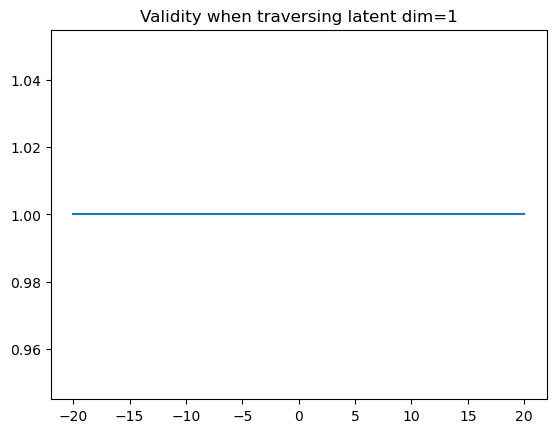

In [65]:
latent_traversal(model, torch.tensor(train_data[np.random.randint(0,len(train_data))]), dim=1, steps=100, max_delta=20)

torch.Size([1, 128])
start smiles: CS(=O)(=O)OCCCOC1=CC=CC=C1
CS(=O)(=O)OCCCOC1=CC=CC=C1 101
CSCC=O 1
CS(=O)(=O)OCCCOC1=CC=CC=C1 3
CS(=O)(=O)OCCCOC1=CCCC=C1 4
CS(=O)(=O)OCCCOC1CCCC=C1 6
CS(=O)(=O)OCCCOC1=CCCC=C1 5
CS(=O)(=O)OCCCOC1CCCC=C1 15
CS(O)(=O)OCCCOC1CCCC=C1 2
CS(O)(=O)OCCCOC1C=CCC=C1 2
CS(O)(=O)OCCCOC1CCCC=C1 7
CS(O)(=O)OCCCOC1C=CCC=C1 2
CS(O)(=O)OCCCOC1CCCC=C1 4
CS(O)(O)OCCCOC1CCCC=C1 2
CSCC=O 1
CS(O)(O)OCCCOC1=CCCC=C1 1
CSCC=O 5
CS(O)(O)OCCCOC1=CCCC=C1 10
CS(=O)(O)OCCCOC1=CCCC=C1 1
CS(O)(O)OCCCOC1=CCCC=C1 1
CS(O)(O)OCCCOC1CCCC=C1 1
CS(O)(O)OCCCOC1=CCCC=C1 1
CS(O)(O)OCCCOC1CCCC=C1 1
CS(O)(O)OCCCOC1C=CCC=C1 4
CS(O)(=O)OCCCOC1CCCC=C1 2
CS(O)(=O)OCCCOC1C=CCC=C1 7
CS(O)(=O)OCCCOC1CCCC=C1 4
CS(O)(=O)OCCCOC1C=CCC=C1 1
CS(O)(=O)OCCCOC1CCCC=C1 3
CS(O)(=O)OCCCOC1=CCCC=C1 3
CS(O)(=O)OCCCOC1CCCC=C1 7
CS(O)(=O)OCCCOC1=CCCC=C1 1
CS(O)(=O)OCCCOC1CCCC=C1 1
CS(O)(=O)OCCCOC1=CCCC=C1 3
CS(O)(=O)OCCCOC1CCCC=C1 5
CN(O)COOCCCOC1CCCC=C1 1
CS(O)(O)OCCCOC1CCCC=C1 1
CS(O)(=O)OCCCOC1CCCC=C1 1
CS(O)(O)O

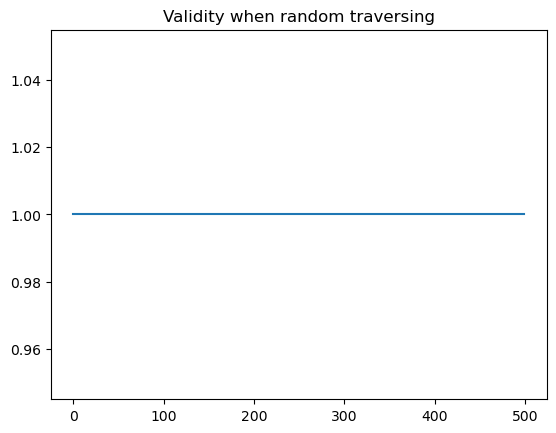

In [68]:
latent_random_traversal(model, val_data, steps=500, sigma=0.01, n_samples=1000)

### 3D plots

In [41]:
from sklearn.decomposition import PCA
import plotly.express as px

# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=len_labels,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by molecule length (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser


In [42]:
# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=carbon_label,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by carbon count (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser

In [ ]:
# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=carbon_label,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by carbon count (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser

In [43]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = go.Figure()

unique_classes = np.unique(oxygen_labels)[::-1]

for cls in unique_classes:
    idx = (oxygen_labels == cls)

    fig.add_trace(go.Scatter3d(
        x=pca_z[idx, 0],
        y=pca_z[idx, 1],
        z=pca_z[idx, 2],
        mode='markers',
        name=f"class {cls}",
        opacity=0.9,
        marker=dict(size=3)   # you can adjust size here
    ))

fig.update_layout(
    title="PCA 3D scatter by oxygen class",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")
